In [1]:
#!pip install shap

In [28]:
import shap
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import root_mean_squared_error
from collections import defaultdict


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

import time

#np.random.seed(42)

SOURCE_PATH = 'data/merged.csv'
def prepare_past_ID_s(data_train):
    """
    This function doesn't used
    """
    data_train['shop_item'] = [tuple([shop, item]) for shop, item in zip(data_train['shop_id'], data_train['item_id'])]
    #34 block contains A LOT more shop_item than others
    shop_item_pairs_in_dbn = data_train.groupby('date_block_num')['shop_item'].apply(np.unique)
    data_train = data_train.drop(['shop_item'], axis=1)
    
    shop_item_pairs_WITH_PREV_in_dbn = shop_item_pairs_in_dbn.copy()
    
    print(np.array(shop_item_pairs_WITH_PREV_in_dbn.index))
    arr = np.array(shop_item_pairs_WITH_PREV_in_dbn.index)
    
    for block in arr[arr>=0]:
        if block == 0:
            continue

        
        arr = np.append(shop_item_pairs_WITH_PREV_in_dbn[block -1],
                                                            shop_item_pairs_in_dbn[block-1])
        
        
        shop_item_pairs_WITH_PREV_in_dbn[block] = np.unique(np.append(shop_item_pairs_WITH_PREV_in_dbn[block -1],
                                                            shop_item_pairs_in_dbn[block-1]))
        print(len(shop_item_pairs_WITH_PREV_in_dbn[block]))

   
    return shop_item_pairs_in_dbn, shop_item_pairs_WITH_PREV_in_dbn

def prepare_past_ID_s_CARTESIAN(data_train):
    """
    Prepares unique (shop, item) pairs in a Cartesian product format over time blocks.
    
    Args:
        data_train (pd.DataFrame): Training data with 'shop_id', 'item_id', and 'date_block_num' columns.

    Returns:
        tuple: A tuple containing:
            - shop_item_pairs_in_dbn (pd.DataFrame): Cartesian product of shop_id and item_id columns from data_train for each 'date_block_num'.
            - shop_item_pairs_WITH_PREV_in_dbn:np.array[np.array[np.array[int]]] Accumulated cartesian products for each time block up since 0 to the previous block. This name may confuse, as it contains only previous information
            
    """
    data_train['shop_item'] = [tuple([shop, item]) for shop, item in zip(data_train['shop_id'], data_train['item_id'])]
    #34 block contains A LOT more shop_item than others
    shop_item_pairs_in_dbn = data_train.groupby('date_block_num')['shop_item'].apply(np.unique)
    data_train = data_train.drop(['shop_item'], axis=1)
    
    shop_item_pairs_WITH_PREV_in_dbn = np.array([None] * len(shop_item_pairs_in_dbn))
    
    #print(np.array(shop_item_pairs_WITH_PREV_in_dbn.index))
    

    cartesians = []
    for dbn in shop_item_pairs_in_dbn.index:
        val = shop_item_pairs_in_dbn[dbn]

        shops = np.unique(list(zip(*val))[0])
        items = np.unique(list(zip(*val))[1])
    
        cartesian_product = np.random.permutation (np.array(np.meshgrid(shops, items)).T.reshape(-1, 2))
        #print(cartesian_product)
        cartesians.append(cartesian_product)
        
    
    shop_item_pairs_WITH_PREV_in_dbn[0] = cartesians[0]
    
    for block in shop_item_pairs_in_dbn.index:
        if block == 0:
            continue
        arr = np.append(shop_item_pairs_WITH_PREV_in_dbn[block - 1],
                             cartesians[block - 1], axis=0)#shop_item_pairs_WITH_PREV_in_dbn doesnt contain 34 month
        
        shop_item_pairs_WITH_PREV_in_dbn[block] = np.unique(arr, axis=0)
        print(len(shop_item_pairs_WITH_PREV_in_dbn[block]))

    for i in range(len(shop_item_pairs_WITH_PREV_in_dbn)):
        shop_item_pairs_WITH_PREV_in_dbn[i] = np.random.permutation(shop_item_pairs_WITH_PREV_in_dbn[i])
    return shop_item_pairs_in_dbn, shop_item_pairs_WITH_PREV_in_dbn

def make_X_lag_format(data, dbn):
    """
    Converts columns with date block numbers to a lag format for specified date block number.

    Args:
        data (pd.DataFrame): Data containing columns with date block numbers. Columns must have format name$dbn
        dbn (int): Current date block number for calculating lags.

    Returns:
        pd.DataFrame: Data with lagged columns for the specified date block number. Columns will have format name_lag;{lag number}
    """
    
    lag_cols = defaultdict()
    for col in data.columns:
        splitted = col.split('$')
        if len(splitted) == 1:
            continue
        
        lag_cols[col] = splitted[0] + '_lag;' + str(dbn - int(splitted[1]))

    #print(lag_cols)
    data = data.rename(columns=dict(lag_cols))
    #print(data.columns)
    return data

def prepare_train(data, valid ):
    """
    Filters training data to include only the specified shop-item pairs.

    Args:
        data (pd.DataFrame): Training data to be filtered.
        valid np.array[np.array[int]]: shop, item pairs to include in a batch.

    Returns:
        pd.DataFrame: Filtered data with only specified shop-item pairs.
    """
    #print(data)
    valid_shop_item = valid
    valid_shop_item = list(zip(*valid_shop_item))
    df = pd.DataFrame({'item_id':valid_shop_item[1],'shop_id':valid_shop_item[0]} )
    data = df.merge(data, on=['shop_id','item_id'], how='inner').fillna(0)

    return data


def prepare_val(data, valid ):
    """
    Filters validation data to include only specified shop-item pairs.

    Args:
        data (pd.DataFrame): Validation data to be filtered.
        valid (np.array[np.array[int]]): shop, item pairs to include in a batch.
    Returns:
        pd.DataFrame: Filtered data for validation with only specified shop-item pairs.
    """
    
    df = pd.DataFrame({'item_id':valid[:,1],'shop_id':valid[:,0]} )
    data = df.merge(data, on=['shop_id','item_id'], how='inner').fillna(0)
    #print('prepare_val, data:',len(data))
    return data

def prepare_data_train_boosting(data, valid, dbn):
    """
    Prepares validation data for boosting models by selecting required columns and selecting only required (shop,item) pairs
    This function was used before reading only part of columns from csv, but still be used to validate everything is right.

    Args:
        data (pd.DataFrame): Training data.
        valid (np.array[np.array[int]]): shop, item pairs to include in a batch.
        dbn (int): Current date block number.

    Returns:
        tuple: 
            - X (pd.DataFrame): Features for training.
            - Y (pd.Series): Target variable for training.
    """
    train = prepare_train (data, valid)
    lag_cols = []
    for col in data.columns:
        
        splitted = col.split('$')
        if len(splitted) == 1:
                lag_cols.append(col)
                continue
        #if 'shop_item_cnt' not in col:
        #    continue
            
        for db in range(0,dbn-1):
            
            if db == int(splitted[1]):
                #print(col)
                lag_cols.append(col)

    #print(lag_cols)
    X = train[lag_cols]
    Y = train[f'value_shop_id_item_id${dbn-1}']
    
    return X, Y


def prepare_data_validation_boosting(data, valid, dbn):
    """
    Prepares validation data for boosting models by selecting required columns and selecting only required (shop,item) pairs
    This function was used before reading only part of columns from csv, but still be used to validate everything is right.
    Args:
        data (pd.DataFrame): Validation data.
        valid (np.array[np.array[int]]): shop, item pairs to include in a batch.
        dbn (int): Current date block number.

    Returns:
        tuple: 
            - X (pd.DataFrame): Features for validation.
            - Y (pd.Series): Target variable for validation.
    """
    test = prepare_val (data, valid)
    
    lag_cols = []
    for col in test.columns:
        
            
        splitted = col.split('$')
        if len(splitted) == 1:
                lag_cols.append(col)
                continue
        for db in range(1,dbn):
            
            if db == int(splitted[1]):
                #print(db, int(''.join(re.findall(r'\d+', col))))
                lag_cols.append(col)

    X = test[lag_cols]
    Y = test[f'value_shop_id_item_id${dbn}']
    
    return X, Y

def select_columns_for_reading(path, dbn):
    """
    Selects relevant columns to read from a CSV file based on the date block number. Feature selection step done here

    Args:
        path (str): Path to the CSV file.
        dbn (int): Date block number used to filter columns.

    Returns:
        list: List of column names to read.
    """
    columns = pd.read_csv(path, nrows=0).columns.tolist()

    cols = []
    for col in columns:
        l = col.split('$')
        if len(l) == 1:
            cols.append(col)
            continue

        name = l[0]
        num=int(l[1])
        dbn_diff = dbn - num
        
        if 'value_shop_id_item_id' in col and np.isclose(dbn_diff,0):#target
            cols.append(col)

        if dbn_diff<=0:
            continue


        if 'ema' in name and dbn_diff <= 2:
            cols.append(col)
            continue
        elif 'value_shop_id_item_id' in name and (dbn_diff <= 3 or dbn_diff == 6 or dbn_diff == 12):
            cols.append(col)
            continue
        elif 'value_price' in name and dbn_diff <= 1:
            cols.append(col)
            continue
        elif 'value' in name and dbn_diff <= 3:
            cols.append(col)
            continue
        elif 'diff' in name and dbn_diff == 1:
            cols.append(col)
            continue
        elif 'change' in name and dbn_diff <= 2:
            cols.append(col)
            continue


    return cols

def sample_indexes(shop_item_pairs_WITH_PREV_in_dbn, number_of_batches):
    """
    Samples indexes for batch learning. Indexes must be applied on shop_item_pairs_WITH_PREV_in_dbn
    Args:
        shop_item_pairs_WITH_PREV_in_dbn ( np.array[np.array[np.array[int]]] ): array of accumulated cartesian products of (shop, item) for date_block_nums
        batch_size (int): batch size for lgbm
        number_of_batches (int): number of batches for lgbm,

    Returns:
        list[list[tuple]]: list of batch indexes for each date_block_num. 
    """
    
    lengthes = np.array(list(map(len, shop_item_pairs_WITH_PREV_in_dbn)))

    batch_size_in_dbn =lengthes // number_of_batches
    #print(lengthes)

    to_ret=[]#this will contain last_monthes_to_take_in_train array, where each array contains split for batches for some dbn
    for bs in batch_size_in_dbn:
        idxs_in_dbn = []
        for i in range(number_of_batches):
            idxs_in_dbn.append((i*bs,(i+1)*bs))
        #print(np.max(idxs_in_dbn))
        to_ret.append(idxs_in_dbn)

    return to_ret

def create_batch_train(batch_size, dbn, shop_item_pairs_WITH_PREV_in_dbn, batch_size_to_read):
    """
    Creates training batches for date_block_num.

    Args:
        batch_size (int): Number of samples per batch.
        dbn (int): Date block number.
        shop_item_pairs_WITH_PREV_in_dbn (np.array[np.array[np.array[int]]]):  Accumulated cartesian products for each time block.
        batch_size_to_read (int): Chunk size for reading data from csv.

    Yields:
        tuple: 
            - X (pd.DataFrame): Feature batch.
            - Y (pd.Series): Target batch.
    """
    last_monthes_to_take_in_train = 14
    lengthes = np.array(list(map(len, shop_item_pairs_WITH_PREV_in_dbn))) 
    
    total_number_of_samples=sum(lengthes[dbn-last_monthes_to_take_in_train+1:dbn+1])
    number_of_batches = total_number_of_samples // batch_size if batch_size <= total_number_of_samples else 1

    #This variable will store batch indexes for date_block_nums [ dbn-last_monthes_to_take_in_train+1 , dbn]
    idxs = sample_indexes(shop_item_pairs_WITH_PREV_in_dbn[dbn-last_monthes_to_take_in_train+1:dbn+1],number_of_batches)
    print('total batches,',number_of_batches)
    for batch_number in range(number_of_batches):
        dbns = []
        batch = []
        l_x=[]
        l_y=[]
        t1 = time.time()
        #This loop enables to includa data from different monthes in one batch
        for dbn_inner in range(last_monthes_to_take_in_train):
            curr_dbn = ((dbn_inner+1) - last_monthes_to_take_in_train) + dbn # in [dbn-last_monthes_to_take_in_train+1,dbn]
            #idxs[dbn_inner] contains batch indexes for dbn_inner block(this array contains elements for [dbn-last_monthes_to_take_in_train+1,dbn] date_block_nums
            
            train = shop_item_pairs_WITH_PREV_in_dbn[curr_dbn][idxs[dbn_inner][batch_number][0] : idxs[dbn_inner][batch_number][1] ]

            
            columns = select_columns_for_reading(SOURCE_PATH,curr_dbn-1)
            #(dbn-1) because this dbn is for validation, dbn for train is 1 less
            merged = pd.read_csv('data/merged.csv', skipinitialspace=True, usecols=columns)
            
            

            l_sum = 0
            
            l =  prepare_data_train_boosting(merged,train,curr_dbn) 
            l_sum += len(l[0])
            l_0 = make_X_lag_format(l[0], curr_dbn-1)#-1 because this dbn is for validation, dbn for train is 1 less

            l_0=append_some_columns(l_0, curr_dbn-1)

            l_x.append( l_0 )
            l_y. append(l[1])
            
            if len(l_x) == 0:
                yield [None, None]

            #print(f'create_batch_train, dbn {curr_dbn}:',l_sum)
        t2 = time.time()
        print('batch creation time [create_batch_train, 212],',t2-t1)
                
        l_x = pd.concat(l_x)
        l_y = pd.concat(l_y)
        print('batch size', len(l_x))
        print(f'batch {batch_number} memory usage',np.sum(l_x.memory_usage()) / 10**6)
        yield [l_x, l_y]#, test

def create_batch_val(batch_size, dbn, shop_item_pairs_in_dbn, batch_size_to_read):
    """
    Creates validation batches for date_block_num.

    Args:
        batch_size (int): Number of samples per batch.
        dbn (int): Date block number.
        shop_item_pairs_in_dbn (pd.DataFrame): dataframe of cartesian products of (shop, item) for date_block_nums
        batch_size_to_read (int): Chunk size for reading data.

    Yields:
        tuple: 
            - X (pd.DataFrame): Feature batch.
            - Y (pd.Series): Target batch.
    """
    val = shop_item_pairs_in_dbn[dbn]
    
    shops = np.unique(list(zip(*val))[0])
    items = np.unique(list(zip(*val))[1])

    cartesian_product = np.random.permutation (np.array(np.meshgrid(shops, items)).T.reshape(-1, 2))
    
    chunk_num =  len(cartesian_product)// batch_size if len(cartesian_product)%batch_size==0  else   len(cartesian_product) // batch_size + 1#MAY BE NEED TO CORRECT

    columns = select_columns_for_reading(SOURCE_PATH, dbn)


    for idx in range(chunk_num):
        merged = pd.read_csv('data/merged.csv', chunksize=batch_size_to_read, skipinitialspace=True, usecols=columns)
        l_x=[]
        l_y=[]
        l_sum=0
        cartesian = cartesian_product[idx*batch_size:(idx+1)*batch_size]

        for chunck in merged:

            l =  prepare_data_validation_boosting(chunck,cartesian, dbn) 
            l_sum+=len(l[0])
            l_x.append( l[0] )
            l_y. append( l[1] )

        if len(l_x) == 0:
            return [None, None]
        print('create_batch_val,243:',l_sum)
        l_x = pd.concat(l_x)
        l_y = pd.concat(l_y)


        return [l_x,l_y]#, test


def append_some_columns(X_train, dbn):
    """
    Adds additional columns like date_block_num and month to the training data.

    Args:
        X_train (pd.DataFrame): Training data.
        dbn (int): Current date block number.

    Returns:
        pd.DataFrame: Training data with additional columns.
    """
    X_train['date_block_num'] = dbn
    X_train['month'] = dbn%12
    return X_train

def train_model(model, batch_size, val_month, shop_item_pairs_WITH_PREV_in_dbn,batch_size_to_read,epochs,shop_item_pairs_in_dbn):
    """
    Trains a machine learning model with specified batches and tracks RMSE for training on current val_month.
    Args:
        model (object): Machine learning model to be trained.
        batch_size (int): Number of samples per batch.
        val_month (int): Month used for validation.
        shop_item_pairs_WITH_PREV_in_dbn (np.array[np.array[np.array[int,int]]]):  Accumulated cartesian products for each time block.
        batch_size_to_read (int): Chunk size for reading data from csv.
        epochs (int): Number of epochs for training. 
        shop_item_pairs_in_dbn (pd.DataFrame, optional): dataframe of cartesian products of (shop, item) for date_block_nums. If None, validation is not performed after every batch

    Returns:
        tuple: 
            - model (object): Trained model.
            - columns_order (list[str]): Ordered list of feature columns.
    """
    first=True
    rmse = 0
    c=0
    columns_order=None
    
    Y_true_l = []
    preds_l = []
    for epoch in range(epochs):
        print('epoch,',epoch)
        for X_train,Y_train  in create_batch_train(batch_size, val_month,shop_item_pairs_WITH_PREV_in_dbn,batch_size_to_read):
            #print(f'train on batch {c} started')
            t1_batch = time.time()
            t1_data_prep = time.time()
            #print(f'data preparation on batch {c} started')
            if X_train is None:
                print('None')
                continue

            if type(model) in [Lasso,SVC]:
                #print(X_train.columns)
                X_train.drop('shop_id', inplace=True, axis=1) 
                X_train.drop('item_category_id', inplace=True, axis=1) 
                X_train.drop('item_id', inplace=True, axis=1)
                X_train.drop('city', inplace=True, axis=1)
                X_train.drop('shop_id', inplace=True, axis=1)
            elif type(model) ==LGBMRegressor:
                #print(list(X_train.columns))
            
                X_train = X_train.drop('item_id', axis=1)
                X_train['shop_id'] = X_train['shop_id'].astype('category')
                X_train['item_category_id'] = X_train['item_category_id'].astype('category')
                X_train['city'] = X_train['city'].astype('category')
                X_train['super_category'] = X_train['super_category'].astype('category')
                
                pass
            
            
                
            Y_train = np.clip(Y_train,0,20)
            
            if X_train.empty:
                print('None')
                continue
            
            #X_train = make_X_lag_format(X_train, val_month-1)#-1 because this dbn is for validation, dbn for train is 1 less
            
            #X_train=select_columns(X_train, val_month-1)
            
            
            columns_order=X_train.columns

            t2_data_prep = time.time()
            #print(f'data preparation on batch {c} time:',t2_data_prep-t1_data_prep)
            #print('model fitting started')
            t1_fit = time.time()
            if c == 0:
                pass
                #print('train columns')
                #print(X_train.columns)
            if type(model) in [Lasso,SVC]:
                model.fit(X_train, Y_train)
                y_train_pred = model.predict(X_train)
            
            elif type(model) == LGBMRegressor:
                if first:
                    model.fit(X_train, Y_train)
                    first=False
                else:
                    model.fit(X_train, Y_train, init_model=model)
                y_train_pred = model.predict(X_train, validate_features=True)

            elif type(model) == xgb.XGBRegressor:
                if first:
                    model=model.fit(X_train, Y_train)
                    first=False
                else:
                    print(model.get_booster())
                    #Works not as expected
                    model=model.fit(X_train, Y_train, xgb_model=model.get_booster())
                    
                    
                y_train_pred = model.predict(X_train)  

            elif type(model) == RandomForestRegressor:
                model.fit(X_train, Y_train)
                y_train_pred = model.predict(X_train)  
            t2_fit = time.time()
            #print(f'model fitting time on batch {c},',t2_fit - t1_fit)
            
            Y_true_l.append(Y_train)
            preds_l.append(y_train_pred)
            t2_batch = time.time()
            print(f'train on batch {c} time,',t2_batch-t1_batch)

            c+=1
        
    train_rmse = root_mean_squared_error(pd.concat(Y_true_l), np.concat(preds_l))
    print('train_rmse, ',train_rmse)
           

    return model, columns_order

In [3]:
import xgboost as xgb
import lightgbm as lgb

In [4]:
def validate_ML(val_monthes, shop_item_pairs_in_dbn, shop_item_pairs_WITH_PREV_in_dbn,batch_size_to_read):
    """
    Function for validating model
    
    """
    model=None
    for val_month in val_monthes:
        
        
        model = LGBMRegressor(verbose=-1,n_jobs=8, num_leaves=48, n_estimators = 500, learning_rate=0.00685)     
        epochs=1
        batch_size=3000000#Mustnt be less then 1200000 
        X_val_to_ret = None
        print(type(model))
        explainer=None
        if type(model) == LGBMRegressor:

            
            
          
            model,columns_order = train_model(model, batch_size, val_month, shop_item_pairs_WITH_PREV_in_dbn,batch_size_to_read,epochs,shop_item_pairs_in_dbn)

            X_val, Y_val = create_batch_val(batch_size, val_month, shop_item_pairs_in_dbn, batch_size_to_read)#but then cartesian product used
            
            Y_val = np.clip(Y_val,0,20)
            X_val = make_X_lag_format(X_val, val_month)
            X_val = X_val.drop('item_id', axis=1)
            X_val['shop_id'] = X_val['shop_id'].astype('category')
            X_val['item_category_id'] = X_val['item_category_id'].astype('category')
            X_val['city'] = X_val['city'].astype('category')
            X_val['super_category'] = X_val['super_category'].astype('category')
            X_val=append_some_columns(X_val,val_month)

            X_val=X_val[columns_order]
            


            print('shap calculation started...')
            explainer = shap.TreeExplainer(model)
            shap_values = explainer(X_val)
            X_val_to_ret=X_val
            

        

    return model,explainer,shap_values,X_val_to_ret

In [5]:
data_train = pd.read_csv('../data_cleaned/data_train.csv')
test = pd.read_csv('../data_cleaned/test.csv')
test['date_block_num'] = 34
data_train = pd.concat([data_train,test ], ignore_index=True).drop('ID', axis=1).fillna(0)
batch_size_to_read=10**10

shop_item_pairs_in_dbn, shop_item_pairs_WITH_PREV_in_dbn = prepare_past_ID_s_CARTESIAN(data_train)

364950
428871
466086
494493
532909
566259
587979
609623
627192
664844
686985
719696
730116
746129
775024
799403
814628
828506
851457
871899
890066
928598
952398
976804
987057
997953
1013772
1025692
1035736
1046582
1055558
1067461
1080188
1110590


In [6]:
#NOW TRAIN ON ONLY FIRST BATCH (for time improvement) (results on validation for all batches are similar)


start_val_month=[33]

model, explainer, shaps, X_display = validate_ML(
                    val_monthes=start_val_month, 
                    shop_item_pairs_in_dbn=shop_item_pairs_in_dbn,
                    shop_item_pairs_WITH_PREV_in_dbn=shop_item_pairs_WITH_PREV_in_dbn,
                    batch_size_to_read=batch_size_to_read
)
print(shaps)

<class 'lightgbm.sklearn.LGBMRegressor'>
epoch, 0
total batches, 4
batch creation time [create_batch_train, 212], 628.4756038188934
batch size 3482437
batch 0 memory usage 1170.098832
train on batch 0 time, 182.17963695526123
train_rmse,  0.43105701324619117
create_batch_val,243: 238084
shap calculation started...
.values =
array([[ 2.11588139e-03, -3.36010678e-04,  3.28514322e-03, ...,
        -1.61665643e-04, -1.27567685e-04, -1.09971949e-03],
       [ 8.39195013e-04, -1.02473517e-03, -3.03374059e-03, ...,
         4.45579458e-05, -1.20821230e-04, -3.70192069e-04],
       [ 9.93444029e-03,  1.82548502e-03,  1.06773977e-02, ...,
         1.60006552e-04, -1.46330898e-04, -4.64531187e-04],
       ...,
       [-1.06388803e-02, -1.02228706e-03, -1.23647618e-02, ...,
        -5.91934220e-05, -1.41953459e-04, -1.20271341e-03],
       [-1.28019030e-03, -9.22928734e-04, -4.66069855e-03, ...,
         8.26906544e-05, -1.27271415e-04, -4.18263968e-04],
       [ 1.34885634e-01,  3.63349864e-02, 

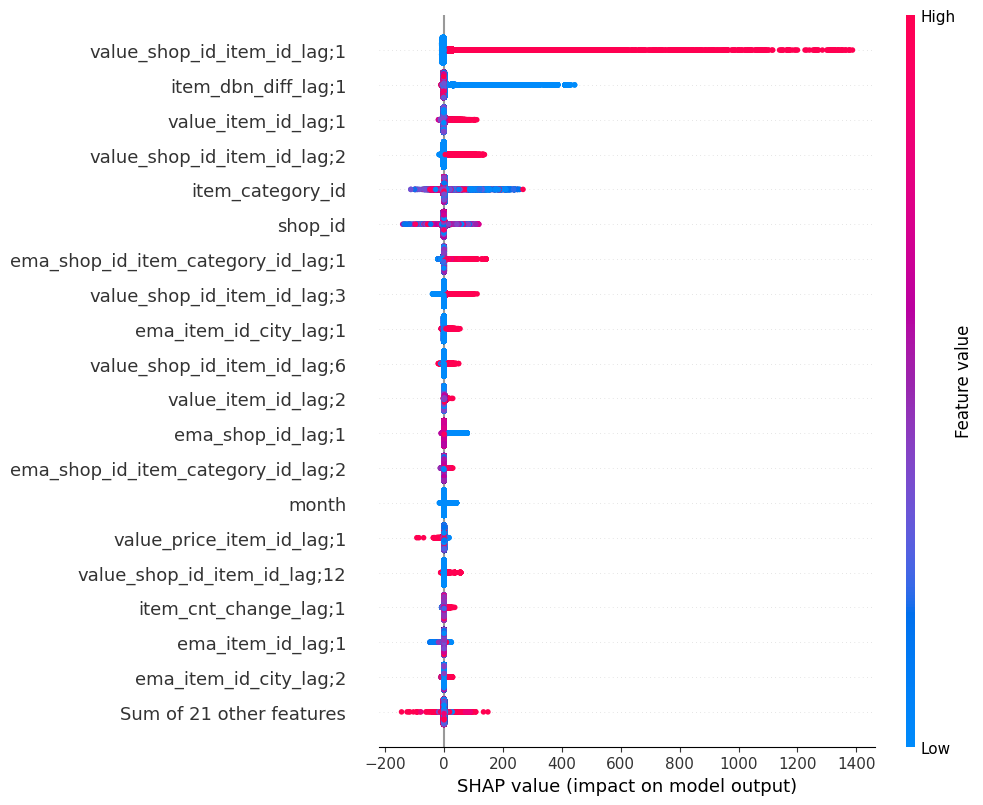

In [33]:

shap.plots.beeswarm(shaps, max_display=20)

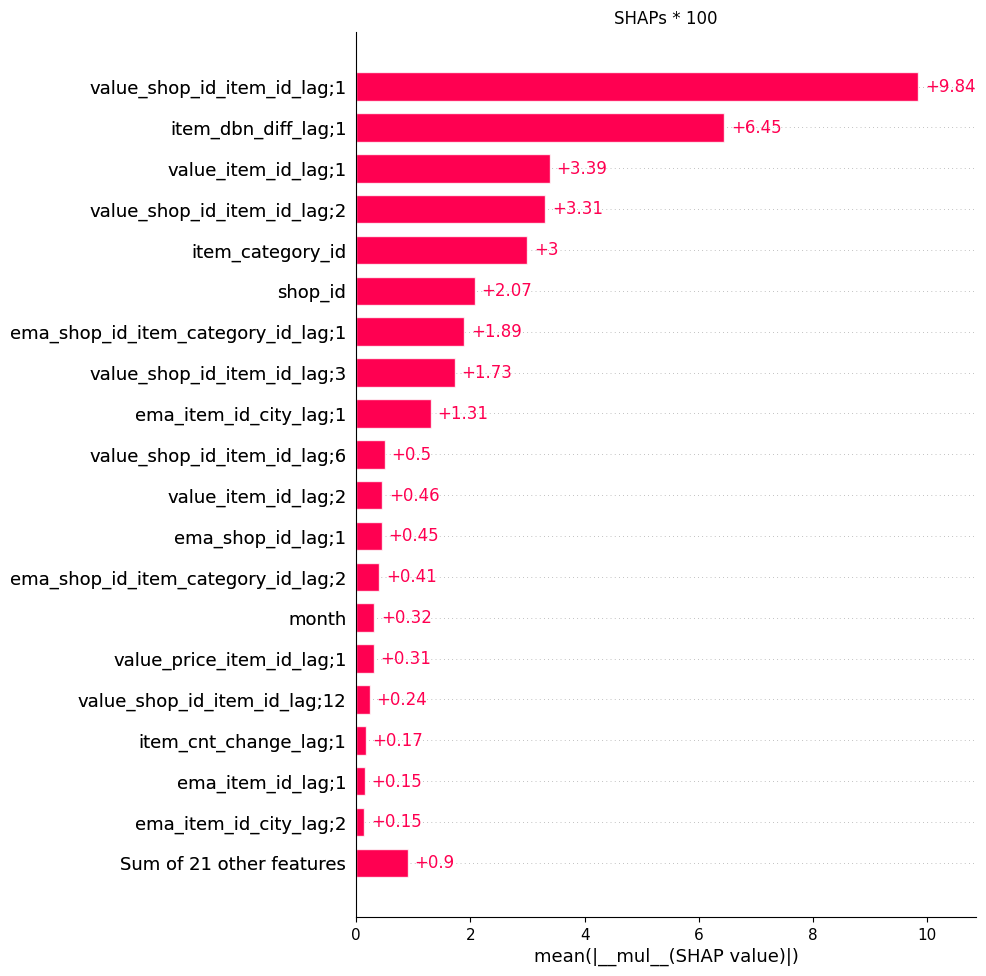

In [32]:
plt.title('SHAPs * 100')
shap.plots.bar(shaps * 100, max_display=20)


In [36]:
shap.initjs()
shap.force_plot(explainer.expected_value, shaps.values[10000, :], X_display.iloc[10000, :])